<a href="https://colab.research.google.com/github/zhe0/prac/blob/main/multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoMM for Image + Text + Tabular - Quick Start

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/stable/docs/tutorials/multimodal/multimodal_prediction/beginner_multimodal.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/stable/docs/tutorials/multimodal/multimodal_prediction/beginner_multimodal.ipynb)



AutoMM is a deep learning "model zoo" of model zoos. It can automatically build deep learning models that are suitable for multimodal datasets. You will only need to convert the data into the multimodal dataframe format
and AutoMM can predict the values of one column conditioned on the features from the other columns including images, text, and tabular data.

In [2]:
!nvidia-smi

Sat Feb 10 05:16:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip -qqq install pip --upgrade
!pip -qqq install torch==2.0.1+cu117 --extra-index-url https://download.pytorch.org/whl/nightly/cu117
!pip -qqq install autogluon.multimodal
!pip -qqq install typing_extensions==4.8.0 --force-reinstall
!pip install -qqq accelerate

In [ ]:
!pip uninstall torchaudio -y

In [1]:
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

## Dataset

For demonstration, we use a simplified and subsampled version of [PetFinder dataset](https://www.kaggle.com/c/petfinder-adoption-prediction). The task is to predict the animals' adoption rates based on their adoption profile information. In this simplified version, the adoption speed is grouped into two categories: 0 (slow) and 1 (fast).

To get started, let's download and prepare the dataset.

In [ ]:
# download_dir = './ag_automm_tutorial'
# zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_for_tutorial.zip'
# from autogluon.core.utils.loaders import load_zip
# load_zip.unzip(zip_file, unzip_dir=download_dir)

!gdown 16_Ql6zKjm8ugpzh-_9zsP2rKAN5BjG-c
!unzip -o /content/petfinder_for_tutorial.zip

Next, we will load the CSV files.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

dataset_path='/content/petfinder_for_tutorial'
data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
train_data,test_data=train_test_split(data,test_size=0.1)
print(len(train_data),len(test_data))
train_data.head()

label_col = 'AdoptionSpeed'
# 我們預計要predict AdoptionSpeed的可能值，越短越快
train_data[label_col].unique()

540 60


array([1, 0])

We need to expand the image paths to load them in training.

In [3]:
image_col = 'Images'
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0]) # Use the first image for a quick tutorial
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])


def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

print('img path and file name: ',train_data[image_col].iloc[0])

example_row = train_data.iloc[0]
print('first row info: ',example_row)

print('PET Description: ',example_row['Description'])

img path and file name:  /content/petfinder_for_tutorial/images/87a679d31-1.jpg
first row info:  Type                                                             1
Name                                                       Xiao Ke
Age                                                              6
Breed1                                                         307
Breed2                                                           0
Gender                                                           1
Color1                                                           2
Color2                                                           0
Color3                                                           0
MaturitySize                                                     2
FurLength                                                        2
Vaccinated                                                       1
Dewormed                                                         2
Sterilized                      

Each animal's adoption profile includes pictures, a text description, and various tabular features such as age, breed, name, color, and more. Let's look at an example row of data and display the text description and a picture.

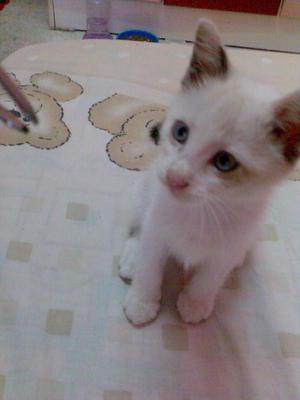

In [ ]:
example_image = example_row[image_col]

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)

AutoGluon infers the feature types to be by constructing a FeatureMetadata object from the training data

In [ ]:
from autogluon.tabular import FeatureMetadata
feature_metadata = FeatureMetadata.from_df(train_data)
feature_metadata

## Training
Now let's fit the predictor with the training data. Here we set a tight time budget for a quick demo.

In [ ]:
# ref:
# https://auto.gluon.ai/0.4.0/tutorials/tabular_prediction/tabular-quickstart.html#presets

In [ ]:
from autogluon.multimodal import MultiModalPredictor
predictor = MultiModalPredictor(
    label=label_col, hyperparameters={
    "env.num_gpus": -1})  # use all GPUs)
p={'train_data':train_data,
  'time_limit':120, # seconds
  'presets':'best_quality',
   }

predictor.fit(**p)

No path specified. Models will be saved in: "AutogluonModels/ag-20240210_053415"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          2
Pytorch Version:    2.0.1+cu117
CUDA Version:       11.7
Memory Avail:       10.64 GB / 12.67 GB (84.0%)
Disk Space Avail:   44.85 GB / 78.19 GB (57.4%)
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/788M [00:00<?, ?B/s]

GPU Count: 1
GPU Count to be Used: 1
GPU 0 Name: Tesla T4
GPU 0 Memory: 0.25GB/15.0GB (Used/Total)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type                | Params
----------------------------------------------------------
0 | model             | MultimodalFusionMLP | 384 M 
1 | validation_metric | BinaryAUROC         | 0     
2 | loss_func         | CrossEntropyLoss    | 0     
----------------------------------------------------------
384 M     Trainable params
0         Non-trainable params
384 M     Total params
1,536.361 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Epoch 0, global step 1: 'val_roc_auc' reached 0.63597 (best 0.63597), saving model to '/content/AutogluonModels/ag-20240210_053415/epoch=0-step=1.ckpt' as top 3
INFO: Time limit reached. Elapsed time is 0:03:20. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

In [1]:
results = predictor.fit_summary(show_plot=True)
results

NameError: name 'predictor' is not defined

In [ ]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

Under the hood, AutoMM automatically infers the problem type (classification or regression), detects the data modalities, selects the related models from the multimodal model pools, and trains the selected models. If multiple backbones are available, AutoMM appends a late-fusion model (MLP or transformer) on top of them.


## Evaluation
Then we can evaluate the predictor on the test data.

In [16]:
scores = predictor.evaluate(test_data, metrics=["roc_auc"])
scores #1800 半小時有七成七的準確率

Predicting: 0it [00:00, ?it/s]

{'roc_auc': 0.7719688542825361}

In [ ]:
predictor.leaderboard(test_data, silent=True)

## Prediction
Given a multimodal dataframe without the label column, we can predict the labels.

In [17]:
predictions = predictor.predict(test_data.drop(columns=label_col))
predictions[:5]

Predicting: 0it [00:00, ?it/s]

367    1
54     1
547    1
348    1
400    0
Name: AdoptionSpeed, dtype: int64

For classification tasks, we can get the probabilities of all classes.

In [18]:
probas = predictor.predict_proba(test_data.drop(columns=label_col))
probas[:5]

Predicting: 0it [00:00, ?it/s]

,0,1
367,0.009671,0.990329
54,0.297266,0.702734
547,0.029901,0.970099
348,0.037397,0.962603
400,0.576438,0.423562


## Extract Embeddings

Extracting embeddings can also be useful in many cases, where we want to convert each sample (per row in the dataframe) into an embedding vector.

In [19]:
embeddings = predictor.extract_embedding(test_data.drop(columns=label_col))
embeddings.shape

Predicting: 0it [00:00, ?it/s]

(60, 128)

In [21]:
predictor.list_supported_models() #支援的pretrained model
# predictor.problem_property #關於模組的一些資訊

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

## Save and Load
It is also convenient to save a predictor and re-load it.

```{warning}

`MultiModalPredictor.load()` uses `pickle` module implicitly, which is known to be insecure. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling. Never load data that could have come from an untrusted source, or that could have been tampered with. **Only load data you trust.**

```

In [ ]:
import uuid

model_path = f"./tmp/{uuid.uuid4().hex}-saved_model"
predictor.save(model_path)
loaded_predictor = MultiModalPredictor.load(model_path)
scores2 = loaded_predictor.evaluate(test_data, metrics=["roc_auc"])
scores2

## Other Examples

You may go to [AutoMM Examples](https://github.com/autogluon/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization
To learn how to customize AutoMM, please refer to [Customize AutoMM](../advanced_topics/customization.ipynb).